## **Câu 1: Classification - Fake and real news dataset (1.0 điểm)**
Use fake-and-real-news-dataset to build a model to determine if an article is fake news or not.
Read more information here:
https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.3/spark-3.1.3-bin-hadoop3.2.tgz
!tar xf spark-3.1.3-bin-hadoop3.2.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.3-bin-hadoop3.2"

In [ ]:
import findspark
findspark.init()

In [ ]:
import pyspark
from pyspark import SparkContext
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession

from pyspark.sql import functions as F
from pyspark.sql.functions import *
from pyspark.sql.types import *

from pyspark.ml.feature import Tokenizer,StopWordsRemover
from pyspark.ml.feature import CountVectorizer,IDF,StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vector

from scipy import stats
from datetime import datetime
from pyspark.sql.functions import mean, stddev, col, log
from pyspark.sql.functions import to_date, dayofweek, to_timestamp
from pyspark.sql import types 
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DateType
from pyspark.sql.functions import year, month
from pyspark.sql.functions import dayofmonth, weekofyear
from pyspark.sql.functions import split, explode
from pyspark.sql.functions import coalesce, first, lit
from pyspark.ml.feature import Binarizer, OneHotEncoder, Bucketizer, VectorAssembler, StringIndexer
from pyspark.sql.functions import round

from pyspark.sql.functions import regexp_extract, col
from pyspark.sql.functions import datediff
from pyspark.sql.functions import when

from pyspark.ml.linalg import Vectors


In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import NaiveBayes, RandomForestClassifier, DecisionTreeClassifier, GBTClassifier, LinearSVC
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import LogisticRegressionModel

from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import datetime
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
%cd '/content/gdrive/My Drive/LDS9_K273_ONLINE_Đinh Viết Trung/LDS9_K273_DinhVietTrung_Cuoi_ky'

Mounted at /content/gdrive
/content/gdrive/My Drive/LDS9_K273_ONLINE_Đinh Viết Trung/LDS9_K273_DinhVietTrung_Cuoi_ky


In [ ]:
from pyspark import SparkContext
sc = SparkContext()


In [ ]:
spark = SparkSession(sc)

In [ ]:
df_true = spark.read.csv('data/fake-and-real-news-dataset/True.csv', inferSchema=True, header=True)
df_fake = spark.read.csv('data/fake-and-real-news-dataset/Fake.csv', inferSchema=True, header=True)

## **Phân tích khai phá dữ liệu và tiền xử lý (EDA & Preprocessing)**

In [ ]:
df_true.show(5)

+--------------------+--------------------+------------+------------------+
|               title|                text|     subject|              date|
+--------------------+--------------------+------------+------------------+
|As U.S. budget fi...|WASHINGTON (Reute...|politicsNews|December 31, 2017 |
|U.S. military to ...|WASHINGTON (Reute...|politicsNews|December 29, 2017 |
|Senior U.S. Repub...|WASHINGTON (Reute...|politicsNews|December 31, 2017 |
|FBI Russia probe ...|WASHINGTON (Reute...|politicsNews|December 30, 2017 |
|Trump wants Posta...|SEATTLE/WASHINGTO...|politicsNews|December 29, 2017 |
+--------------------+--------------------+------------+------------------+
only showing top 5 rows



In [ ]:
df_true.count()

21417

In [ ]:
df_fake.show(5)

+--------------------+--------------------+-------+-----------------+
|               title|                text|subject|             date|
+--------------------+--------------------+-------+-----------------+
| Donald Trump Sen...|Donald Trump just...|   News|December 31, 2017|
| Drunk Bragging T...|House Intelligenc...|   News|December 31, 2017|
| Sheriff David Cl...|On Friday, it was...|   News|December 30, 2017|
| Trump Is So Obse...|On Christmas day,...|   News|December 29, 2017|
| Pope Francis Jus...|Pope Francis used...|   News|December 25, 2017|
+--------------------+--------------------+-------+-----------------+
only showing top 5 rows



In [ ]:
df_fake.count()

23489

In [ ]:
df_true.printSchema()

root
 |-- title: string (nullable = true)
 |-- text: string (nullable = true)
 |-- subject: string (nullable = true)
 |-- date: string (nullable = true)



In [ ]:
df_fake.printSchema()

root
 |-- title: string (nullable = true)
 |-- text: string (nullable = true)
 |-- subject: string (nullable = true)
 |-- date: string (nullable = true)



'''
Kiểu dữ liệu các cột của df_true và df_fake đều là string
df_true có 21417 records
df_fake có 23489 records

Vì làm việc giữa 2 dataframe sẽ gây bất tiện => em gộp vào 1 dataframe và tạo 1 column là label 
để phân biệt records nào là true, records nào là fake
'''

In [ ]:
df_true = df_true.withColumn('label', lit('true'))
df_fake = df_fake.withColumn('label', lit('fake'))

In [ ]:
df = df_true.union(df_fake)

In [ ]:
df.show(5)

+--------------------+--------------------+------------+------------------+-----+
|               title|                text|     subject|              date|label|
+--------------------+--------------------+------------+------------------+-----+
|As U.S. budget fi...|WASHINGTON (Reute...|politicsNews|December 31, 2017 | true|
|U.S. military to ...|WASHINGTON (Reute...|politicsNews|December 29, 2017 | true|
|Senior U.S. Repub...|WASHINGTON (Reute...|politicsNews|December 31, 2017 | true|
|FBI Russia probe ...|WASHINGTON (Reute...|politicsNews|December 30, 2017 | true|
|Trump wants Posta...|SEATTLE/WASHINGTO...|politicsNews|December 29, 2017 | true|
+--------------------+--------------------+------------+------------------+-----+
only showing top 5 rows



In [ ]:
df.count()

44906

'''
df là dataframe sau khi union df_true và df_fake
=> có 21417 + 23489 = 44906 records
khi này, df sẽ có 2 nhóm là fake và true tương ứng với data của df_true và df_fake
'''

'''
=> dựa vào dataset và yêu cầu đề, ta thấy:\
    - **input (preditor)**: <> label: tất cả các thuộc tính trừ label\
    - **output (target)**: label

data type:\
    - string
'''

### **Clean Data**

### **Check missing data**

In [ ]:
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas().T

,0
title,0
text,8
subject,8
date,8
label,0


In [ ]:
'''
Có giá trị null => xóa nào
'''

'\nCó giá trị null => xóa nào\n'

In [ ]:
df = df.dropna()

In [ ]:
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas().T

,0
title,0
text,0
subject,0
date,0
label,0


In [ ]:
'''
=> đã ko còn giá trị null nào nữa
'''

'\n=> đã ko còn giá trị null nào nữa\n'

In [ ]:
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()

+-----+----+-------+----+-----+
|title|text|subject|date|label|
+-----+----+-------+----+-----+
|    0|   0|      0|   0|    0|
+-----+----+-------+----+-----+



In [ ]:
'''
ô kìa, vui quá! df không có nan values
'''

'\nô kìa, vui quá! df không có nan values\n'

### **Check duplicates**

In [ ]:
total = df.count()
distinct = df.distinct().count()

print('df có', total, 'records')
print('df có', distinct, 'distinct records')

print(('df có các duplicate records với', total - distinct, 'duplicate records') if total > distinct else 'df không có các duplicate records')

df có 44898 records
df có 44466 distinct records
('df có các duplicate records với', 432, 'duplicate records')


In [ ]:
'''
Có duplicate => xóa đi nàooo
'''

'\nCó duplicate => xóa đi nàooo\n'

In [ ]:
df = df.drop_duplicates()
df.count()

44466

In [ ]:
total = df.count()
distinct = df.distinct().count()

print('df có', total, 'records')
print('df có', distinct, 'distinct records')

print(('df có các duplicate records với', total - distinct, 'duplicate records') if total > distinct else 'df không có các duplicate records')

df có 44466 records
df có 44466 distinct records
df không có các duplicate records


In [ ]:
'''
dataset đã ko còn duplicate
'''

'\ndataset đã ko còn duplicate\n'

### **Phân tích các biến**

In [ ]:
df_pd = df.toPandas()

In [ ]:
def check_duplicate(df, column):
    total = df[[column]].count()
    distinct = df[[column]].distinct().count()

    print(column, 'có', total, 'records')
    print(column, 'có', distinct, 'distinct records')
    if total > distinct:
        print(column, 'có các duplicate records với ' + str(total - distinct) + ' duplicate records')
    else:
        print(column, 'ko có duplicate records')

In [ ]:
def show_hist_for_col(dataset, column, title):
    """
    Display a histogram for a column in a dataframe, splitting the data by label.
    """
    plt.figure(figsize=(15,6))
    dataset[dataset.label == 'true'][column].hist(label='True')
    dataset[dataset.label == 'fake'][column].hist(alpha=0.4, label='Fake')
    #plt.title(title)
    plt.legend()
    plt.xlabel(title)
    plt.show()

In [ ]:
# Remove stopwords and remove words with 2 or less characters
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stop_words:
            result.append(token)
            
    return result

### **Title**

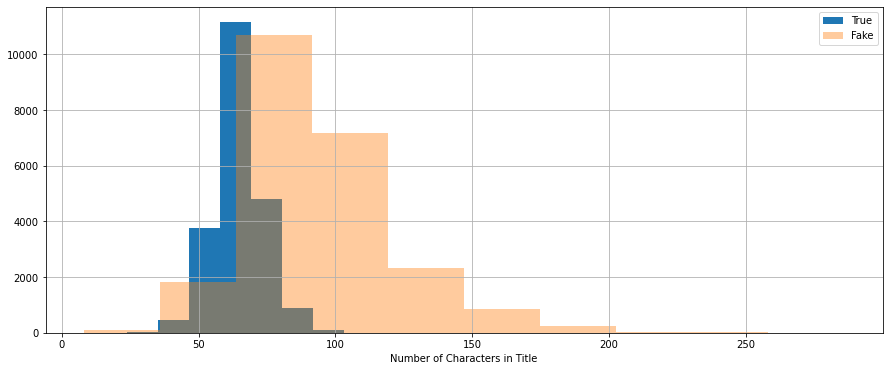

In [ ]:
df_pd['title_len'] = df_pd.title.apply(len)
show_hist_for_col(df_pd, 'title_len', 'Number of Characters in Title')


In [ ]:
'''
Nhìn biểu đồ, ta thấy: nếu title càng dài (khoảng > 100) hoặc càng ngắn (khoảng từ 0-25) thì khả năng cao là Fake
title True phân phối nhiều ở các title có độ dài từ 50 -> khoảng 80 
'''

'\nNhìn biểu đồ, ta thấy: nếu title càng dài (khoảng > 100) hoặc càng ngắn (khoảng từ 0-25) thì khả năng cao là Fake\ntitle True phân phối nhiều ở các title có độ dài từ 50 -> khoảng 80 \n'

In [ ]:
check_duplicate(df, 'title')

title có 44466 records
title có 38728 distinct records
title có các duplicate records với 5738 duplicate records


'''
Dễ thấy, các title trong dataset có thể trùng lắp, có nghĩa là có một vài title được tái sử dụng nhiều lần
'''

In [ ]:
df.select('title').distinct().collect() # output dài lắm, ko nên show hidden output ạ:)))

[Row(title='U.S. states could not set self-driving car rules under Republican plan'),
 Row(title=' Justice Department Announces It Will No Longer Use Private Prisons'),
 Row(title='UNHINGED RADICAL LEFTISTS Try To Storm Trump’s Utah Rally Attacking Police And Secret Service With Rocks [Video]'),
 Row(title='North Korea may announce completion of nuclear program within a year: South Korea minister'),
 Row(title='U.N. Security Council to meet on North Korea missile test on Friday'),
 Row(title="Serbian, U.S. paratroopers to earn 'wings' during bilateral military exercise"),
 Row(title='Kenyan President Kenyatta wins 98 percent of vote in repeat election'),
 Row(title="BLACK FEMALE RAPPER Endorses Trump: “Black Folks Have Been Voting Democrat For Last 70 Years And We Don’t Have Shit To Show For It…Hillary Treats Us Like ‘PETS'”"),
 Row(title='IRONY ALERT: CNN HOST That Called Trump A “Piece of Sh*t” Eats Human Brains Then Hosts Throw Sh*t At Him…THREATEN TO BEHEAD HIM'),
 Row(title='BEAUT

'''
sau khi xem xét các giá trị unique của title, ta ko thấy các giá trị rác nào (vd như các ký tự ?, ##, ...)
'''

In [ ]:
title_mode = df.groupby("title").count().orderBy("count", ascending=False).first()[0]

print('title dc tái sử dụng nhiều nhất', title_mode)

title dc tái sử dụng nhiều nhất Factbox: Trump fills top jobs for his administration


In [ ]:
df.filter(df.title == title_mode).show()

+--------------------+--------------------+------------+------------------+-----+
|               title|                text|     subject|              date|label|
+--------------------+--------------------+------------+------------------+-----+
|Factbox: Trump fi...|(Reuters) - Presi...|politicsNews|November 30, 2016 | true|
|Factbox: Trump fi...|(Reuters) - Presi...|politicsNews|December 17, 2016 | true|
|Factbox: Trump fi...|(Reuters) - U.S. ...|politicsNews| January 19, 2017 | true|
|Factbox: Trump fi...|(Reuters) - U.S. ...|politicsNews|December 15, 2016 | true|
|Factbox: Trump fi...|(Reuters) - U.S. ...|politicsNews|November 29, 2016 | true|
|Factbox: Trump fi...|(Reuters) - U.S. ...|politicsNews| December 5, 2016 | true|
|Factbox: Trump fi...|(Reuters) - U.S. ...|politicsNews| December 7, 2016 | true|
|Factbox: Trump fi...|(Reuters) - Presi...|politicsNews|December 19, 2016 | true|
|Factbox: Trump fi...|(Reuters) - U.S. ...|politicsNews| December 8, 2016 | true|
|Factbox: Trump 

'''
Vì mỗi bài text đều có các title, các title này có thể giống nhau.
Ngoài ra, còn phải quan tâm tới các subject của text đó.
Vì vậy, trước khi quyết định drop, chúng ta cần phải xem và phân tích biến text cùng các biến khác
'''

### **Text**

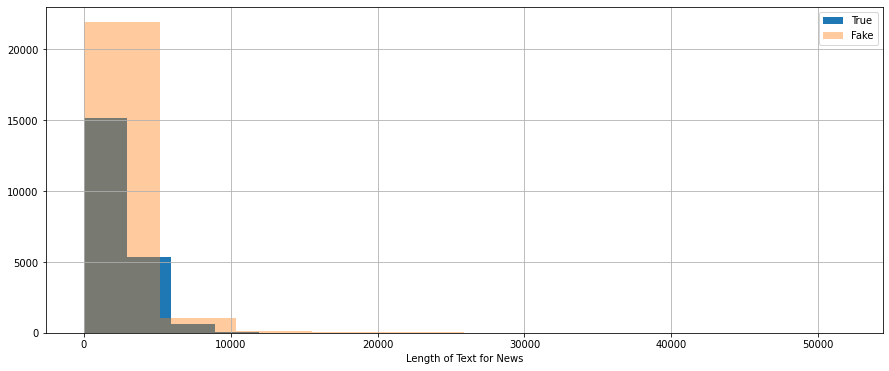

In [ ]:
df_pd['text_len'] = df_pd.text.apply(len)
show_hist_for_col(df_pd, 'text_len', 'Length of Text for News')


In [ ]:
'''
Nhìn chung, dựa vào độ dài của text thì không thể phân biệt quá rõ ràng True hay Fake news
'''

'\nNhìn chung, dựa vào độ dài của text thì không thể phân biệt quá rõ ràng True hay Fake news\n'

In [ ]:
check_duplicate(df, 'text')

text có 44466 records
text có 38644 distinct records
text có các duplicate records với 5822 duplicate records


In [ ]:
text_mode = df.groupby("text").count().orderBy("count", ascending=False).first()[0]

print('title dc tái sử dụng nhiều nhất', text_mode)

title dc tái sử dụng nhiều nhất  


'''
title dc tái sử dụng nhiều nhất là ' ' (là 1 khoảng trắng)
' ' xuất hiện nhiều lần trong df, điều này nghĩa là dataset có title nhưng ko có text.
Có thể là vô ý (người nhập quên ko nhập text, hay bị mất mát text, nhập sai cột, ...) 
hoặc là cố ý (title đó thật sự ko có text)
'''

In [ ]:
df.filter(col('text') == ' ').count()

627

In [ ]:
'''
Nhìn sơ lược, ta có thể đoán dc, nếu text là ' ' thì đó là fake:))
'''

"\nNhìn sơ lược, ta có thể đoán dc, nếu text là ' ' thì đó là fake:))\n"

In [ ]:
df = df.withColumn('text', when(col('text') == ' ', None) .otherwise(df.text))

In [ ]:
df.filter(col('text') == ' ').count()

0

In [ ]:
print(df.count())
df = df.dropna(subset=('text'))
print(df.count())



44466
43839


In [ ]:
#df.filter(col('text') == np.nan).show()

### **Date**

'''
Quan sát tổng quan dữ liệu, ta thấy cột date có chứa các loại format data khác nhau:
vd như string date còn có loại là string số (vd: 9/4/2017) hay string chuỗi (vd: september/4/2017 hay sep/4/2017), ...
Ngoài ra còn có các giá trị rác như là url, một strong text nào đó


'''

In [ ]:
def not_a_date(string):
    """
    Check if the input string can be converted to a date.
    
    Return:
    True if it is not a date
    False if it is a date
    """
    try:
        date = pd.to_datetime(string)
        return False
    except ValueError:
        return True

In [ ]:
df_pd = df.toPandas()

In [ ]:
df_pd_bad_date = df_pd[df_pd['date'].apply(not_a_date)]

In [ ]:
df_pd_bad_date.head()

,title,text,subject,date,label
53,A kiss is not just a kiss on Cleveland convent...,"""CLEVELAND (Reuters) - In an age of social med...",the Media,or a law? Dick to Dick Executive Consulting i...,true
171,WATCH: REMEMBER When President Clinton Took Cr...,"""Bill Clinton was falsely confident in his pla...",2017Clinton chose the Agreed Framework,promising billions of dollars in aid for a No...,fake
310,"""""""The people have spoken",""""" Zimbabwe's Mnangagwa tells cheering crowd""",HARARE (Reuters) - Zimbabwe s former vice pres...,worldnews,true
320,India drags feet on GM mustard permit amid pow...,"""NEW DELHI (Reuters) - India has frozen reques...",matters related to environmental release of t...,""""" the GEAC said in minutes of a meeting relea...",true
352,EXPOSED: Trump Staffers Feed Him A Steady Die...,"""Trump can t handle the truth, and apparently ...",2017According to Politico,staffers have gotten the message. Now they re...,fake


In [ ]:
'''
Nhìn chung, các record này đều là các record bất hợp lệ (date sao có cái giá trị kỳ vậy :)) )
=> drop nàoo
'''

'\nNhìn chung, các record này đều là các record bất hợp lệ (date sao có cái giá trị kỳ vậy :)) )\n=> drop nàoo\n'

In [ ]:
df_pd = df_pd.drop(df_pd_bad_date.index)

In [ ]:
# Convert dates to datetime type
try:
    df_pd['date'] = pd.to_datetime(df_pd['date'])
except ValueError:
    print('Not all date values are dates.')

In [ ]:
'''
Chuyển lại qua pyspark dataframe nào, chứ nếu xử lý bằng pandas.dataframe thì có thể sẽ chậm hơn.
Quan trọng nhất là môn này là bigdata, ai lại dùng như thế chứ :))
'''

'\nChuyển lại qua pyspark dataframe nào, chứ nếu xử lý bằng pandas.dataframe thì có thể sẽ chậm hơn.\nQuan trọng nhất là môn này là bigdata, ai lại dùng như thế chứ :))\n'

In [ ]:
df_new = spark.createDataFrame(df_pd)

In [ ]:
df_new.show(5)

+--------------------+--------------------+------------+-------------------+-----+
|               title|                text|     subject|               date|label|
+--------------------+--------------------+------------+-------------------+-----+
|Kentucky lawmaker...|(Reuters) - Kentu...|politicsNews|2017-12-14 00:00:00| true|
|Pentagon wants 12...|(Reuters) - The P...|politicsNews|2017-12-07 00:00:00| true|
|Exclusive: U.S. d...|WASHINGTON (Reute...|politicsNews|2017-12-04 00:00:00| true|
|Trump criticized ...|WASHINGTON/LONDON...|politicsNews|2017-11-29 00:00:00| true|
|Myanmar operation...|YANGON (Reuters) ...|politicsNews|2017-11-21 00:00:00| true|
+--------------------+--------------------+------------+-------------------+-----+
only showing top 5 rows



In [ ]:
df_new.select(year(col('date'))).distinct().show()

+----------+
|year(date)|
+----------+
|      2018|
|      2015|
|      2016|
|      2017|
+----------+



In [ ]:
'''
về cơ bản, có 4 năm trong dataset
=> chúng ta thử xem tổng quan dữ liệu theo các năm
'''

'\nvề cơ bản, có 4 năm trong dataset\n=> chúng ta thử xem tổng quan dữ liệu theo các năm\n'

In [ ]:
df_new.filter(year(df_new.date) == 2015).show() # output dài quá, chiếm nhiều chỗ nên em hide đi ạ

+--------------------+--------------------+---------------+-------------------+-----+
|               title|                text|        subject|               date|label|
+--------------------+--------------------+---------------+-------------------+-----+
|WATCH: FOX News H...|What do you think...|       politics|2015-12-08 00:00:00| fake|
|HOMELAND SECURITY...|Our Homeland Secu...|       politics|2015-12-07 00:00:00| fake|
|CLINTON’S CLASSIF...|ED HNERY describe...|       politics|2015-11-30 00:00:00| fake|
|WHY THESE TWO “TO...|We can think of t...|       politics|2015-11-06 00:00:00| fake|
|DIAMOND AND SILK ...|These two girls m...|       politics|2015-11-02 00:00:00| fake|
|NOT BREAKING…HILL...|Is it a coinciden...|       politics|2015-09-12 00:00:00| fake|
|BRILLIANT: [VIDEO...|Nothing like a go...|       politics|2015-08-23 00:00:00| fake|
|PRICELESS: Watch ...|Career criminals ...|       politics|2015-07-30 00:00:00| fake|
|CHILLING: How Ame...|The shocking trut...|Government 

In [ ]:
df_new.filter(year(df_new.date) == 2016).show() # output dài quá, chiếm nhiều chỗ nên em hide đi ạ

+--------------------+--------------------+------------+-------------------+-----+
|               title|                text|     subject|               date|label|
+--------------------+--------------------+------------+-------------------+-----+
|Russia says close...|MOSCOW (Reuters) ...|politicsNews|2016-12-12 00:00:00| true|
|White House: Trum...|ABOARD AIR FORCE ...|politicsNews|2016-12-06 00:00:00| true|
|Trump says hopes ...|WEST PALM BEACH, ...|politicsNews|2016-11-26 00:00:00| true|
|Trump Treasury ca...|WASHINGTON (Reute...|politicsNews|2016-11-17 00:00:00| true|
|Factbox: Short li...|(Reuters) - New c...|politicsNews|2016-11-17 00:00:00| true|
|Clinton holds lea...|BOSTON (Reuters) ...|politicsNews|2016-10-28 00:00:00| true|
|Senate bill would...|CHICAGO (Reuters)...|politicsNews|2016-09-27 00:00:00| true|
|In Pennsylvania, ...|WASHINGTON (Reute...|politicsNews|2016-09-13 00:00:00| true|
|U.S. Senate's Rei...|LAS VEGAS (Reuter...|politicsNews|2016-08-29 00:00:00| true|
|Tru

In [ ]:
df_new.filter(year(df_new.date) == 2017).show() # output dài quá, chiếm nhiều chỗ nên em hide đi ạ

+--------------------+--------------------+------------+-------------------+-----+
|               title|                text|     subject|               date|label|
+--------------------+--------------------+------------+-------------------+-----+
|Kentucky lawmaker...|(Reuters) - Kentu...|politicsNews|2017-12-14 00:00:00| true|
|Pentagon wants 12...|(Reuters) - The P...|politicsNews|2017-12-07 00:00:00| true|
|Exclusive: U.S. d...|WASHINGTON (Reute...|politicsNews|2017-12-04 00:00:00| true|
|Trump criticized ...|WASHINGTON/LONDON...|politicsNews|2017-11-29 00:00:00| true|
|Myanmar operation...|YANGON (Reuters) ...|politicsNews|2017-11-21 00:00:00| true|
|Two ex-Trump aide...|WASHINGTON (Reute...|politicsNews|2017-10-30 00:00:00| true|
|Trump, Puerto Ric...|WASHINGTON/NEW YO...|politicsNews|2017-10-18 00:00:00| true|
|Trump does not su...|WASHINGTON (Reute...|politicsNews|2017-10-18 00:00:00| true|
|U.S. Treasury out...|WASHINGTON (Reute...|politicsNews|2017-10-06 00:00:00| true|
|Sen

In [ ]:
df_new.filter(year(df_new.date) == 2018).show() # output dài quá, chiếm nhiều chỗ nên em hide đi ạ

+--------------------+--------------------+--------+-------------------+-----+
|               title|                text| subject|               date|label|
+--------------------+--------------------+--------+-------------------+-----+
|HIGH SCHOOL TEACH...|EAG News  A Wyomi...|politics|2018-02-18 00:00:00| fake|
|IT BEGINS…RINO ME...|A longtime Republ...|politics|2018-02-18 00:00:00| fake|
|WATCH: ’’Carpetba...|The GOP president...|politics|2018-02-18 00:00:00| fake|
|HEY, BERNIE SANDE...|The left has lock...|politics|2018-02-16 00:00:00| fake|
|JUST IN: Senate R...|How could the Sen...|politics|2018-02-15 00:00:00| fake|
|MEGHAN MCCAIN Cut...|It clear that com...|politics|2018-02-17 00:00:00| fake|
|TWO HIGH SCHOOL J...|ABC News  When tw...|politics|2018-02-15 00:00:00| fake|
|LOCAL REPORTER IN...| We took a very h...|politics|2018-02-17 00:00:00| fake|
|POLITICS FIRST: L...|The heartbreaking...|politics|2018-02-15 00:00:00| fake|
|WATCH: SNOWFLAKES...|Ami Horowitz is f...|politics|

In [ ]:
df_new.filter((year(df_new.date) == 2015) & (df_new.label == True)).show()

df_new.filter((year(df_new.date) == 2018) & (df_new.label == True)).show()

+-----+----+-------+----+-----+
|title|text|subject|date|label|
+-----+----+-------+----+-----+
+-----+----+-------+----+-----+

+-----+----+-------+----+-----+
|title|text|subject|date|label|
+-----+----+-------+----+-----+
+-----+----+-------+----+-----+



In [ ]:
'''
Nhìn chung, tất các các dữ liệu trong năm 2015 và 2018 đều là fake news:))
'''

'\nNhìn chung, tất các các dữ liệu trong năm 2015 và 2018 đều là fake news:))\n'

### **subject**

In [ ]:
df_new.groupBy('subject').count().show()

+--------------------+-----+
|             subject|count|
+--------------------+-----+
|             US_News|  767|
|           left-news| 4064|
|           worldnews| 9961|
|            politics| 6111|
|   2017An October 23|    1|
| 2017Commencing a...|    1|
|        politicsNews|11157|
|     Government News| 1470|
|         Middle-east|  762|
|                News| 8501|
+--------------------+-----+



In [ ]:
df_new.filter(df_new.subject.like('%2017%')).show()

+--------------------+--------------------+--------------------+-------------------+-----+
|               title|                text|             subject|               date|label|
+--------------------+--------------------+--------------------+-------------------+-----+
|DISGUSTING! Abusi...|" Shia Labeouf ma...| 2017Commencing a...|2017-01-01 00:00:00| fake|
|JUST IN: PRESIDEN...|"After Judicial W...|   2017An October 23|2016-01-01 00:00:00| fake|
+--------------------+--------------------+--------------------+-------------------+-----+



In [ ]:
'''
có 2 value lẻ loi trong subject là '2017An October 23' và '2017Commencing a...'
có thể đây là lỗi format định dạng của người nhập, ...
'''

"\ncó 2 value lẻ loi trong subject là '2017An October 23' và '2017Commencing a...'\ncó thể đây là lỗi format định dạng của người nhập, ...\n"

In [ ]:
print(df_new.count())
df_new2 = df_new.filter(~df_new.subject.like('%2017%'))
print(df_new2.count())


42795
42793


In [ ]:
df_pd = df_new2.toPandas()

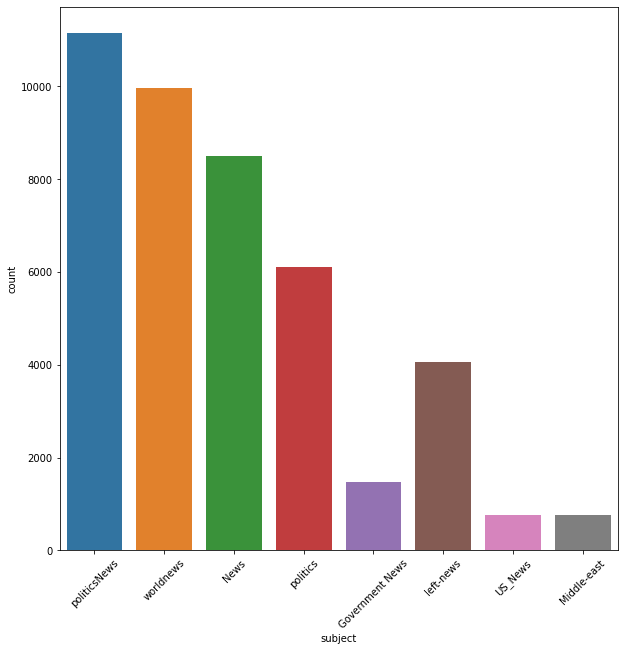

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
plt.xticks(rotation=45)
ax = sns.countplot(x = df_pd.subject)
plt.show()

In [ ]:
'''
Về cơ bản, dataset có 8 subject, trong đó publicNews, worldnews, News và politics chiếm đa số của dataset
'''

'\nVề cơ bản, dataset có 8 subject, trong đó publicNews, worldnews, News và politics chiếm đa số của dataset\n'

### **Label**

In [ ]:
df_new2.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
| fake|21675|
| true|21118|
+-----+-----+



Text(0.5, 1.0, 'target variable count')

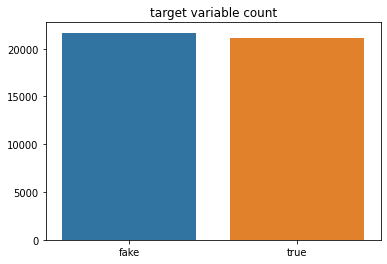

In [ ]:
count = df_pd['label'].value_counts().values
sns.barplot(x = ['fake', 'true'], y = count)
plt.title('target variable count')

In [ ]:
'''
tỉ lệ fake và true khá đồng đều và cân bằng
'''

'\ntỉ lệ fake và true khá đồng đều và cân bằng\n'

In [ ]:
# download stopwords
nltk.download("stopwords")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [ ]:
df_pd['original'] = df_pd['title'] + ' ' + df_pd['text']
df_pd['clean'] = df_pd['original'].apply(preprocess)


In [ ]:
df_pd['clean_joined'] = df_pd['clean'].apply(lambda x: " ".join(x))

In [ ]:
df_pd.head(5)

,title,text,subject,date,label,original,clean,clean_joined
0,Kentucky lawmaker a 'probable suicide' amid se...,(Reuters) - Kentucky state Representative Dan ...,politicsNews,2017-12-14,true,Kentucky lawmaker a 'probable suicide' amid se...,"[kentucky, lawmaker, probable, suicide, amid, ...",kentucky lawmaker probable suicide amid sexual...
1,Pentagon wants 12 month procurement time for m...,(Reuters) - The Pentagon’s acquisition chief s...,politicsNews,2017-12-07,true,Pentagon wants 12 month procurement time for m...,"[pentagon, wants, month, procurement, time, ma...",pentagon wants month procurement time major we...
2,Exclusive: U.S. document certifies Honduras as...,WASHINGTON (Reuters) - The U.S. State Departme...,politicsNews,2017-12-04,true,Exclusive: U.S. document certifies Honduras as...,"[exclusive, document, certifies, honduras, sup...",exclusive document certifies honduras supporti...
3,Trump criticized in Britain and U.S. for shari...,WASHINGTON/LONDON (Reuters) - President Donald...,politicsNews,2017-11-29,true,Trump criticized in Britain and U.S. for shari...,"[trump, criticized, britain, sharing, anti, mu...",trump criticized britain sharing anti muslim v...
4,Myanmar operation against Rohingya has 'hallma...,YANGON (Reuters) - Members of U.S. Congress sa...,politicsNews,2017-11-21,true,Myanmar operation against Rohingya has 'hallma...,"[myanmar, operation, rohingya, hallmarks, ethn...",myanmar operation rohingya hallmarks ethnic cl...


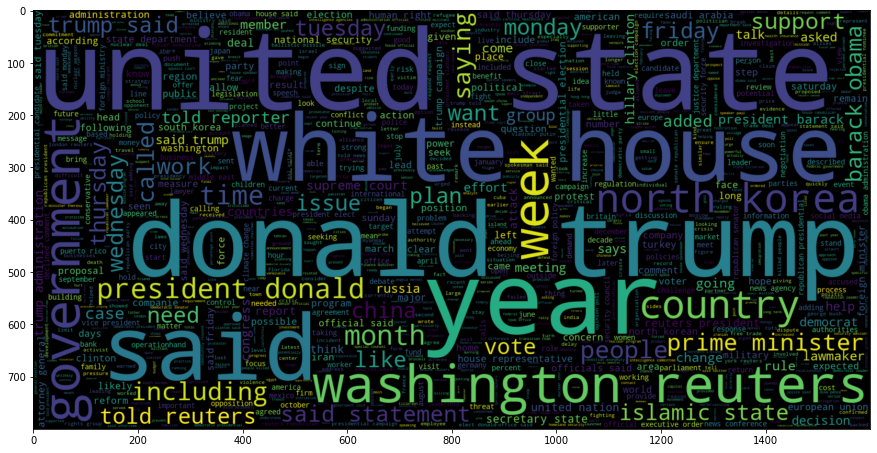

In [ ]:
# word cloud các text có label là true
plt.figure(figsize = (15,18)) 
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df_pd[df_pd.label == 'true'].clean_joined))
plt.imshow(wc, interpolation = 'bilinear')
plt.show()

'''
Nhìn chung, các từ khóa nổi bật của true news là united state, donald trump, white hourse, president, government, north korea, china, ...
=> đây là các sự kiện xoay quanh khi tổng thống Mỹ lúc bấy giờ là donald trump và các chính sách, đường lối của ông ấy, ...
hay key word tuesday dc nhắc đến trong sự kiện Super Tuesday của ông ấy, ...
'''

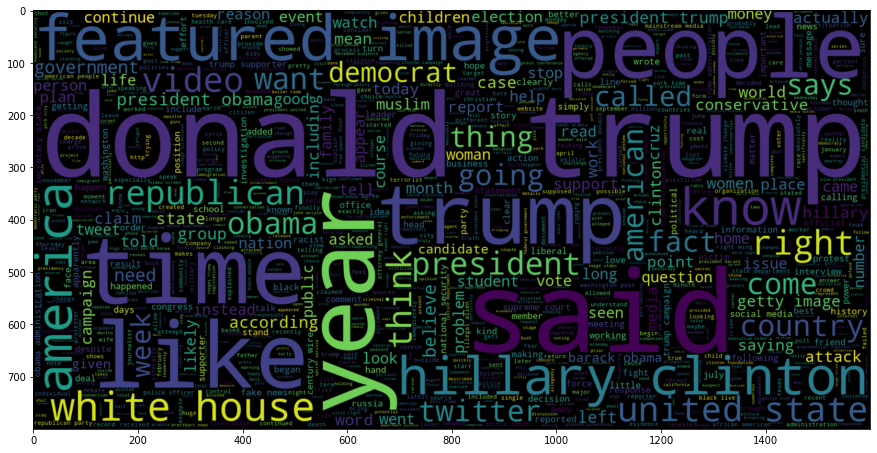

In [ ]:
# word cloud các text có label là fake
plt.figure(figsize = (15,18)) 
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df_pd[df_pd.label == 'fake'].clean_joined))
plt.imshow(wc, interpolation = 'bilinear')
plt.show()

'''
Về fake news, ngoài các từ khóa giống như true news: donald trump, president, government, america, white hourse, ...
thì fake news có các key words nổi bật như people said, twitter, featured image, ...
=> điều này xoay quanh việc người ta đồn đại, bàn tán về các sự kiện chính trị (buôn dưa lê bán dưa chuột :))), đặc biệt là trên twitter.
Ngoài ra, tổng thống donald trump thường xuyên sử dụng twitter để đăng các status 
nên có nhiều tin tức ông ấy đưa lên chỉ là cảm xúc hay là một chiến lược chính trị mang tính tâm lý 
(vd như đàm phàn với Triều Tiên, ông ấy luôn nói là mọi chuyện diễn ra tốt đẹp nhưng thực tế lại là đàm phán thất bại chẳng hạn)

'''

---

'''
sau khi phân tích xong, ta có thể nhận thấy:
3 cột quan trong nhất trong dataset này là title, clean_joined (là text sau khi preprocessing_text) và subject (tất nhiên là có cả label rồi).
Về field date, có thể sẽ ko cần dùng tới.

thật ra, clean_joined đã chứa cả title, tuy nhiên, ta xem xét model nếu score cao thì có thể bỏ luôn cả title, nếu ko thì có thể giữ lại!

'''

In [ ]:
df_new4 = spark.createDataFrame(df_pd[['clean_joined', 'subject', 'label']])

In [ ]:
df_new4 = df_new4.withColumnRenamed('clean_joined', 'new_text_join')
df_new4 = df_new4.withColumnRenamed('label', 'class') # để lát khi Feature Transformations lấy cái tên là label ạ :))

In [ ]:
df_new4.show(5)

+--------------------+------------+-----+
|       new_text_join|     subject|class|
+--------------------+------------+-----+
|kentucky lawmaker...|politicsNews| true|
|pentagon wants mo...|politicsNews| true|
|exclusive documen...|politicsNews| true|
|trump criticized ...|politicsNews| true|
|myanmar operation...|politicsNews| true|
+--------------------+------------+-----+
only showing top 5 rows



In [ ]:
df_new4.count()

42793

In [ ]:
df_new4 = df_new4.withColumn('length',length(df_new4['new_text_join']))
df_new4.show(5)

+--------------------+------------+-----+------+
|       new_text_join|     subject|class|length|
+--------------------+------------+-----+------+
|kentucky lawmaker...|politicsNews| true|  1638|
|pentagon wants mo...|politicsNews| true|  1836|
|exclusive documen...|politicsNews| true|  2050|
|trump criticized ...|politicsNews| true|  4239|
|myanmar operation...|politicsNews| true|   687|
+--------------------+------------+-----+------+
only showing top 5 rows



In [ ]:
df_new4.groupby('class').mean().show()

+-----+------------------+
|class|       avg(length)|
+-----+------------------+
| fake| 1634.439630911188|
| true|1608.1343877261104|
+-----+------------------+



In [ ]:
'''
Về cơ bản, fake và true khá tương đồng nhau về length of text
'''

'\nVề cơ bản, fake và true khá tương đồng nhau về length of text\n'

In [ ]:
df_new4 = df_new4.drop('length')
df_new4.show(5)

+--------------------+------------+-----+
|       new_text_join|     subject|class|
+--------------------+------------+-----+
|kentucky lawmaker...|politicsNews| true|
|pentagon wants mo...|politicsNews| true|
|exclusive documen...|politicsNews| true|
|trump criticized ...|politicsNews| true|
|myanmar operation...|politicsNews| true|
+--------------------+------------+-----+
only showing top 5 rows



In [ ]:
# lưu lại để đề phòng server bị đứt kết nối, em đã bị đứt mấy lần rồi, huhu
# df_new4.write.parquet('Exercise1/cleaning_data.parquet', mode = 'overwrite')

In [ ]:
# read parquet file into dataframe
df_new4 = spark.read.parquet('Exercise1/cleaning_data.parquet')

### **Feature Transformations**

'''
dataset sau khi phân tích và xử lý, về cơ bản sẽ có 3 field:
- new_text_join (biến kiểu text): bao gồm title và text sau khi xử lý và join
- subject (biến category): có 8 giá trị
- label (biến category): có 2 giá trị là true và fake (là biến target) 
'''

In [ ]:
# xử lý data dạng text của new_text_join
tokenizer = Tokenizer(inputCol="new_text_join", outputCol="token_text")
stopremove = StopWordsRemover(inputCol='token_text',outputCol='stop_tokens')
count_vec = CountVectorizer(inputCol='stop_tokens',outputCol='c_vec')
idf = IDF(inputCol="c_vec", outputCol="tf_idf")

# xử lý cột subject
indexer = StringIndexer(inputCol='subject', outputCol='subject_index')
onehot = OneHotEncoder(
    inputCol = 'subject_index',
    outputCol = 'subject_dummy'
)

# xử lý cột class
class_to_num = StringIndexer(inputCol='class', outputCol='label')


In [ ]:
assembler = VectorAssembler(inputCols=['tf_idf', 'subject_dummy'], outputCol='features')

#### **Pipeline**

In [ ]:
data_prep_pipe = Pipeline(stages=[tokenizer, stopremove, count_vec, idf, indexer, onehot, class_to_num, assembler])

In [ ]:
cleaner = data_prep_pipe.fit(df_new4)

In [ ]:
clean_data = cleaner.transform(df_new4)

### **Chuẩn bị dữ liệu train - test**

In [ ]:
clean_data = clean_data.select(['label','features'])

In [ ]:
clean_data.show(10) # label 1 là true, 0 là fake

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  1.0|(103250,[1,2,4,5,...|
|  1.0|(103250,[1,7,17,2...|
|  1.0|(103250,[0,1,2,4,...|
|  1.0|(103250,[0,1,2,3,...|
|  1.0|(103250,[1,3,7,16...|
|  1.0|(103250,[0,1,2,6,...|
|  1.0|(103250,[0,1,2,7,...|
|  1.0|(103250,[0,1,2,7,...|
|  1.0|(103250,[0,1,2,7,...|
|  1.0|(103250,[0,1,2,5,...|
+-----+--------------------+
only showing top 10 rows



In [ ]:
clean_data.filter(col('label') == 1).count()

21118

In [ ]:
clean_data.filter(col('label') == 0).count()

21675

In [ ]:
(training, testing) = clean_data.randomSplit([0.7,0.3])

In [ ]:
training.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|15159|
|  1.0|14748|
+-----+-----+



In [ ]:
training.describe().show()

+-------+-------------------+
|summary|              label|
+-------+-------------------+
|  count|              29907|
|   mean|0.49312869896679706|
| stddev|0.49996114165988415|
|    min|                0.0|
|    max|                1.0|
+-------+-------------------+



In [ ]:
testing.groupBy("label").count().show()


+-----+-----+
|label|count|
+-----+-----+
|  0.0| 6516|
|  1.0| 6370|
+-----+-----+



In [ ]:
testing.describe().show()

+-------+-------------------+
|summary|              label|
+-------+-------------------+
|  count|              12886|
|   mean|0.49433493714108334|
| stddev|0.49998730681686515|
|    min|                0.0|
|    max|                1.0|
+-------+-------------------+



'''
split của cả train và test số dòng true(1) và fake(0) khá đồng đều.
Nhận xét: dựa vào mean, std của 2 tập train và test, 
thấy data phân phối đều
=> ổn nè
'''

In [ ]:
# lưu lại để đề phòng server bị đứt kết nối, em đã bị đứt mấy lần rồi, huhu. Em khổ lắm cô ạ
training.write.parquet('Exercise1/training.parquet', mode = 'overwrite')
testing.write.parquet('Exercise1/testing.parquet', mode = 'overwrite')

### **Xây dựng model**
Chúng ta chọn một vài thuật toán classification:
- Logistics Regression
- Native Bayes
- Decision Tree
- SVC
- Random Forest

In [ ]:
def classification_model_evalution(model_fited, data_train, data_test):
    test_results = model_fited.transform(data_test)

    # Create a confusion matrix
    print('Confusion matrix:')
    test_results.groupBy('label', 'prediction').count().show(5)

    # acc score
    acc_eval = MulticlassClassificationEvaluator()
    acc = acc_eval.evaluate(test_results)

    TN = test_results.filter('prediction = 0 AND label = prediction').count()
    TP = test_results.filter('prediction = 1 AND label = prediction').count()
    FN = test_results.filter('prediction = 0 AND label != prediction').count()
    FP = test_results.filter('prediction = 1 AND label != prediction').count()

    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    # acc = (TP+TN)/(TP+TN+FP+FN)

    print('Accuracy: ', acc)
    print('Precision: ', precision)
    print('Recall: ', recall)


#### **Xây dựng model với Logistic Regression**

In [ ]:
lr = LogisticRegression()

In [ ]:
start_time_logistic_reg = datetime.datetime.now()
predictor = lr.fit(training)
end_time_logistic_reg = datetime.datetime.now()

In [ ]:
logistic_runtime = end_time_logistic_reg - start_time_logistic_reg
logistic_runtime.total_seconds()

90.972196

In [ ]:
df_new4.printSchema()

root
 |-- new_text_join: string (nullable = true)
 |-- subject: string (nullable = true)
 |-- class: string (nullable = true)



In [ ]:
test_results = predictor.transform(testing)

In [ ]:
test_results.show(5)

+-----+--------------------+--------------------+-----------+----------+
|label|            features|       rawPrediction|probability|prediction|
+-----+--------------------+--------------------+-----------+----------+
|  0.0|(103250,[0,1,2,3,...|[118.664145773133...|  [1.0,0.0]|       0.0|
|  0.0|(103250,[0,1,2,3,...|[126.293528963001...|  [1.0,0.0]|       0.0|
|  0.0|(103250,[0,1,2,3,...|[46.4942332657090...|  [1.0,0.0]|       0.0|
|  0.0|(103250,[0,1,2,3,...|[71.5909771900617...|  [1.0,0.0]|       0.0|
|  0.0|(103250,[0,1,2,3,...|[74.3517178916194...|  [1.0,0.0]|       0.0|
+-----+--------------------+--------------------+-----------+----------+
only showing top 5 rows



#### **Đánh giá**

In [ ]:
classification_model_evalution(predictor, training, testing)

Confusion matrix:
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0| 6240|
|  0.0|       1.0|   80|
|  1.0|       0.0|   21|
|  0.0|       0.0| 6431|
+-----+----------+-----+

Accuracy:  0.9920926228378828
Precision:  0.9873417721518988
Recall:  0.9966459032103497


'''
Quan sát confusion matrix, acc, prediction, recall
kết quả đưa ra cao (~~ 0.99)
=> model tốt, phù hợp để sử dụng.

** model đầu tiên mà cho ra điểm cao quá, thấy chọn dc luôn rồi nhưng vẫn phải giả bộ chạy thử các thuật toán khác :(
'''

### **Xây dựng model với NaiveBayes**

In [ ]:
nb = NaiveBayes()

In [ ]:
start_time_nb = datetime.datetime.now()
predictor_2 = nb.fit(training)
end_time_nb = datetime.datetime.now()


In [ ]:
runtime_nb = end_time_nb - start_time_nb
runtime_nb.total_seconds()

59.501395

In [ ]:
test_results_2 = predictor_2.transform(testing)

In [ ]:
test_results_2.show(5)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|  0.0|(103250,[0,1,2,3,...|[-73979.420659549...|           [1.0,0.0]|       0.0|
|  0.0|(103250,[0,1,2,3,...|[-66372.144067304...|           [1.0,0.0]|       0.0|
|  0.0|(103250,[0,1,2,3,...|[-36231.047103709...|[1.0,8.0436826091...|       0.0|
|  0.0|(103250,[0,1,2,3,...|[-49023.080335626...|           [1.0,0.0]|       0.0|
|  0.0|(103250,[0,1,2,3,...|[-49033.145821354...|           [1.0,0.0]|       0.0|
+-----+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



#### **Đánh giá**

In [ ]:
classification_model_evalution(predictor_2, training, testing)

Confusion matrix:
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0| 5849|
|  0.0|       1.0|  310|
|  1.0|       0.0|  412|
|  0.0|       0.0| 6201|
+-----+----------+-----+

Accuracy:  0.9434576389901621
Precision:  0.949667153758727
Recall:  0.9341958153649577


'''
Quan sát confusion matrix, acc, prediction, recall
kết quả đưa ra cao (~~ 0.94)
=> model tốt, phù hợp để sử dụng.
'''

### **Xây dựng model với Decision Tree Classifier**

In [ ]:
dt = DecisionTreeClassifier()

In [ ]:
start_time_dt = datetime.datetime.now()
predictor_3 = dt.fit(training)
end_time_dt = datetime.datetime.now()

In [ ]:
runtime_dt = end_time_dt - start_time_dt
runtime_dt.total_seconds()

345.537906

In [ ]:
predictor_3.transform(testing).show(5)

+--------------------+------------+-----+--------------------+--------------------+--------------------+--------------------+-------------+-------------+-----+--------------------+--------------+--------------------+----------+
|       new_text_join|     subject|class|          token_text|         stop_tokens|               c_vec|              tf_idf|subject_index|subject_dummy|label|            features| rawPrediction|         probability|prediction|
+--------------------+------------+-----+--------------------+--------------------+--------------------+--------------------+-------------+-------------+-----+--------------------+--------------+--------------------+----------+
|abadi defends rol...|   worldnews| true|[abadi, defends, ...|[abadi, defends, ...|(103243,[1,4,7,9,...|(103243,[1,4,7,9,...|          1.0|(7,[1],[1.0])|  1.0|(103250,[1,4,7,9,...|[31.0,14734.0]|[0.00209955976972...|       1.0|
|abandoned tourist...|   worldnews| true|[abandoned, touri...|[abandoned, touri...|(1032

In [ ]:
classification_model_evalution(predictor_3, training, testing)

Confusion matrix:
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0| 6361|
|  0.0|       1.0|   13|
|  0.0|       0.0| 6507|
+-----+----------+-----+

Accuracy:  0.9989907731332339
Precision:  0.9979604643865705
Recall:  1.0


'''
uầy, quá tuyệt với luôn, acc, recall, prediction đều rất cao
kết quả đưa ra cao (~~ 1) -> gần như tuyệt đối luôn rồi, đáng sợ quá :))
=> model tốt, phù hợp để sử dụng.


'''

### **Build model với SVC**

In [ ]:
svc =  LinearSVC()

In [ ]:
start_time_svc = datetime.datetime.now()
predictor_4 = svc.fit(training)
end_time_svc = datetime.datetime.now()

In [ ]:
runtime_svc = end_time_svc - start_time_svc
runtime_svc.total_seconds()

1197.698207

In [ ]:
predictor_4.transform(testing).show(5)

+--------------------+------------+-----+--------------------+--------------------+--------------------+--------------------+-------------+-------------+-----+--------------------+--------------------+----------+
|       new_text_join|     subject|class|          token_text|         stop_tokens|               c_vec|              tf_idf|subject_index|subject_dummy|label|            features|       rawPrediction|prediction|
+--------------------+------------+-----+--------------------+--------------------+--------------------+--------------------+-------------+-------------+-----+--------------------+--------------------+----------+
|abadi defends rol...|   worldnews| true|[abadi, defends, ...|[abadi, defends, ...|(103243,[1,4,7,9,...|(103243,[1,4,7,9,...|          1.0|(7,[1],[1.0])|  1.0|(103250,[1,4,7,9,...|[-7.3837944443156...|       1.0|
|abandoned tourist...|   worldnews| true|[abandoned, touri...|[abandoned, touri...|(103243,[1,3,7,13...|(103243,[1,3,7,13...|          1.0|(7,[1],[1

In [ ]:
classification_model_evalution(predictor_4, training, testing)

Confusion matrix:
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0| 6305|
|  0.0|       1.0|   23|
|  1.0|       0.0|   56|
|  0.0|       0.0| 6497|
+-----+----------+-----+

Accuracy:  0.993866701541289
Precision:  0.9963653603034134
Recall:  0.991196352774721


'''
Quan sát confusion matrix, acc, prediction, recall
kết quả đưa ra cao (~~ 0.99)
=> model tốt, phù hợp để sử dụng.
'''

### **Build model với Random Forest**

In [ ]:
rf = RandomForestClassifier()

In [ ]:
start_time_rf = datetime.datetime.now()
predictor_5 = rf.fit(training)
end_time_rf = datetime.datetime.now()

In [ ]:
runtime_rf = end_time_rf - start_time_rf
runtime_rf.total_seconds()

301.966212

In [ ]:
classification_model_evalution(predictor_5, training, testing)

Confusion matrix:
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0| 5906|
|  0.0|       1.0| 1214|
|  1.0|       0.0|  455|
|  0.0|       0.0| 5306|
+-----+----------+-----+

Accuracy:  0.8700729093673855
Precision:  0.8294943820224719
Recall:  0.9284703662946078


In [ ]:
'''
Quan sát confusion matrix, acc, prediction, recall
kết quả đưa tạm ổn
=> model khá ổn, có thể sử dụng.
'''

'\nQuan sát confusion matrix, acc, prediction, recall\nkết quả đưa tạm ổn\n=> model khá ổn, có thể sử dụng.\n'

## **Đánh giá và lựa chọn các thuật toán**

'''
sau khi build model với các thuật toán 
Logistics Regression, Native Bayes, Decision Tree, SVC, Random Forest

Nhìn chung, các thuật toán đều cho ra kết quả tốt.
Trong đó, SVC, Logistic cho acc, recall, prediction ~0.99 và Decision Tree cho acc, recall, prediction ~1

tuy nhiên, các thuật toán có thời gian build, train model khá lâu, trong đó Native Bayes cho thời gian chạy nhanh nhất
Ở đây vì thời gian và tài nguyên không cho phép và đã có thuật toán có score rất cao rồi nên em không xử lý phần hyper parameters nữa mà truyền
default parameters cho các model. Nếu kết hợp cả params, khả năng cao Native Bayes phù hợp nhất khi vừa cho ra score cao mà thời gian fit nhanh.

Và ở phần này, em chọn Decision Tree cho dataset này do có score cao nhất.
'''

### **Lưu model**

In [ ]:
from pyspark.ml.classification import DecisionTreeClassificationModel

In [ ]:
predictor_3.save('Exercise1/ex1_decision_tree_model')

In [ ]:
dt_load = DecisionTreeClassificationModel.load("Exercise1/ex1_decision_tree_model")